# portfolio

> A module to model a portfolio's performance over the available time-scale including the impact of fees.

A notebook to explore different investment portfolio ideas and compare their historic returns, inclusive of fees

In [1]:
#| default_exp portfolio

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
import yfinance as yf
import pendulum
%matplotlib inline

# Holding
A holding is an asset that can be bought. We need to track it's value and how much of it we own over time. We therefore need financial data which can be provided by yfinance for free.

Let's import the package and have a play. Remembering that when we are using `nbdev` we have to have imports in their own cells.

In [4]:
import yfinance as yf

In [5]:
price_history = yf.Ticker('VWELX').history(period='max', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                           interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                           actions=False)
price_history.head()

,Open,High,Low,Close,Volume
Date,,,,,
1980-01-02,0.560007,0.560007,0.560007,0.560007,0
1980-01-03,0.557518,0.557518,0.557518,0.557518,0
1980-01-04,0.560629,0.560629,0.560629,0.560629,0
1980-01-07,0.560629,0.560629,0.560629,0.560629,0
1980-01-08,0.567473,0.567473,0.567473,0.567473,0


yfinance appears to be a good option as it has price information. One concern would be what units these are but that doesn't matter as we will convert back to cash at the end.

In [6]:
show_doc(yf.Ticker.history)

---

### TickerBase.history

>      TickerBase.history (period='1mo', interval='1d', start=None, end=None,
>                          prepost=False, actions=True, auto_adjust=True,
>                          back_adjust=False, proxy=None, rounding=False,
>                          tz=None, timeout=None, **kwargs)

:Parameters:
    period : str
        Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        Either Use period parameter or use start and end
    interval : str
        Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        Intraday data cannot extend last 60 days
    start: str
        Download start date string (YYYY-MM-DD) or _datetime.
        Default is 1900-01-01
    end: str
        Download end date string (YYYY-MM-DD) or _datetime.
        Default is now
    prepost : bool
        Include Pre and Post market data in results?
        Default is False
    auto_adjust: bool
        Adjust all OHLC automatically? Default is True
    back_adjust: bool
        Back-adjusted data to mimic true historical prices
    proxy: str
        Optional. Proxy server URL scheme. Default is None
    rounding: bool
        Round values to 2 decimal places?
        Optional. Default is False = precision suggested by Yahoo!
    tz: str
        Optional timezone locale for dates.
        (default data is returned as non-localized dates)
    timeout: None or float
        If not None stops waiting for a response after given number of
        seconds. (Can also be a fraction of a second e.g. 0.01)
        Default is None.
    **kwargs: dict
        debug: bool
            Optional. If passed as False, will suppress
            error message printing to console.

## Deposits

Deposits to our fund could be naturally specified as time series of deposits. A helper function is provided to support the creation of monthly deposits. However, this could be extended to different time periods.

In [27]:
import pandas as pd
from datetime import datetime

In [35]:
def create_monthly_deposits(start:str,        # Date of the first montly deposit.
                            end:str,          # Date of the last monthly deposit
                            deposit:float):    # Value of monthly deposit
    to_datetime = lambda date_string: datetime.strptime(date_string,"%d/%m/%Y")
    dti = pd.date_range(start=to_datetime(start),end=to_datetime(end),freq='M')
    deposits = [deposit]*len(dti)
    return pd.Series([deposit]*len(dti), index=dti)

We call our function as follows.

In [34]:
create_monthly_deposits('21/01/1999','02/11/2022',10)

1999-01-31    10
1999-02-28    10
1999-03-31    10
1999-04-30    10
1999-05-31    10
              ..
2022-06-30    10
2022-07-31    10
2022-08-31    10
2022-09-30    10
2022-10-31    10
Freq: M, Length: 286, dtype: int64

## Single Holding
First we create a portfolio consisting of a single holding.

In [36]:
import matplotlib.pyplot as plt

In [61]:
class Holding:
    "A holding for fund with data available on yfinance"
    def __init__(self,
                 fund:str,                      # Name of the fund
                 ticker:str,                    # Ticker symbol for the stock
                 product_cost:float,            # Sum of all fees expressed as a percentage
                 deposits:list)                 # Timeseries dataframe of deposits
                 
        
        self.fund = fund
        self.history = yf.Ticker(ticker).history(period='max', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                                 interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                                 actions=False)
        self.history['deposits']  = [annual_deposit/365,]*len(self.history)
        self.history['units']     = self.history['deposits']/self.history['Close']
        self.history['cum_units'] = self.history['units'].cumsum()
        self.history['cum_value'] = self.history['cum_units']*self.history['Close']
        self.history['fees'] = ((1+product_cost/100)**(1/365)-1)*self.history['cum_value']
        
    def profit(self):
        return self.history['cum_value'][-1]-sum(self.history['deposits'])
        
    def plot(self):
        'Plot value of the holding'
        plt.plot(price_history['Close'])
        plt.xticks(rotation = 90)
        plt.title(self.fund)
        return plt

In [74]:
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

We can plot the value of a holding over a time sp

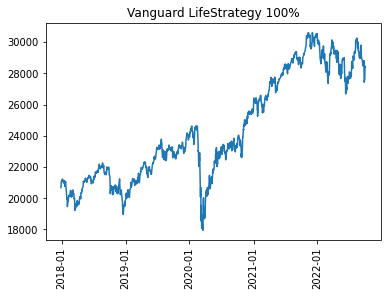

In [72]:
single_holding = Holding('Vanguard LifeStrategy 100%','0P0000TKZO.L',0.22)
plt = single_holding.plot()
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(1,6))

In [73]:
round(single_holding.profit())

17551

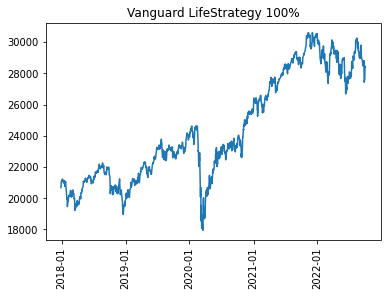

In [70]:
price_history = yf.Ticker('0P0000TKZO.L').history(period='max', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                                  interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                                  actions=False)
price_history = price_history[price_history['Close']>300]
plt.plot(price_history['Close'])
plt.xticks(rotation = 90)
plt.title('Vanguard LifeStrategy 100%')
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(1,6))

Now we construct our investment scenario of a regular investment that maximises the UK ISA allowance.

In [68]:
price_history['deposits']=[20000/365,]*len(price_history)
price_history.head()

,Open,High,Low,Close,Volume,deposits
Date,,,,,,
2018-01-02,20677.300781,20677.300781,20677.300781,20677.300781,0,54.794521
2018-01-03,20863.699219,20863.699219,20863.699219,20863.699219,0,54.794521
2018-01-04,20965.300781,20965.300781,20965.300781,20965.300781,0,54.794521
2018-01-05,21076.099609,21076.099609,21076.099609,21076.099609,0,54.794521
2018-01-08,21060.300781,21060.300781,21060.300781,21060.300781,0,54.794521


12520.006478919051


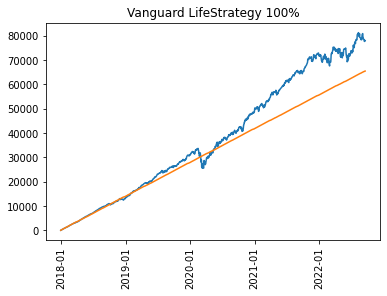

In [70]:
plt.plot(price_history['cum_value']-price_history['fees'].cumsum())
plt.plot(price_history['deposits'].cumsum())
plt.xticks(rotation = 90)
plt.title('Vanguard LifeStrategy 100%')
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(1,6))
profit = price_history.iloc[-1,price_history.columns.get_loc("cum_value")]-price_history['deposits'].sum()-price_history['fees'].sum()
print(profit)

# Portfolio Modelling
For portfolio analysis, I'd like to explore the following features:
* Modelling a porfolio consisting of multiple funds.
* Rebalancing to target allocations.
* Rebalancing at given frequency.
    
Proposed structure would be lists of fund names, tickers, allocations and ongoing charges. A deposit rate would also need to be defined. Rebalancing times could be specified as a date series.

Future functionality might include:
* Variable allocation.
* Definition of deposits in time.

In [54]:
funds = ["Scottish Mortgage Ord","Fundsmith Equity I Acc"];
tickers = ["GB00BLDYK618","GB00B41YBW71"]
allocation = [0.5, 0.5]
annual_deposit = 20000
rebalance_rate = "monthly"
product_cost = [0.66, 0.99]

# Create data frames for each allocation
price_history_list = list()
for i in range(len(funds)):
    price_history = yf.Ticker(tickers[i]).history(period='max', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                                  interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                                  actions=False)
    price_history['deposits']=[annual_deposit/365*allocation[i],]*len(price_history)
    price_history['units'] = price_history['deposits']/price_history['Close']
    price_history_list.append(price_history)

# Trim price_history_list to earliest date in portfolio
# Start by finding the first date data was available for each portfolio
first_timestamp = list ()
for price_history in price_history_list:
    first_timestamp.append(price_history.index[1])
start_date = max(first_timestamp)
    
# Now trim data and compute cumulutative values
for i in range(len(price_history_list)):
    price_history_list[i] = price_history_list[i][price_history_list[i].index >= start_date]
    price_history_list[i].insert(0,'cum_units',price_history_list[i]['units'].cumsum())
    price_history_list[i].insert(0,'cum_value',price_history_list[i]['cum_units']*price_history_list[i]['Close'])

# Rebalance
# Start by creating rebalance series
from datetime import datetime
import pandas as pd
rebalance_dates = pd.date_range(start_date,datetime.now(tz=None), freq='M')

# Find allocation of rebalance dates
for i_date in range(len(rebalance_dates)):
    
    # Find current asset allocation
    value_breakdown = list()
    for i_fund in range(len(price_history_list)):
        price_history = price_history_list[i_fund]
        matching_row = price_history.index.get_indexer([rebalance_dates[i_date]],method='nearest')[0]
        value_breakdown.append(price_history.iloc[matching_row].loc['cum_value']) # Include fees here?

    # Computer targer allocations based on asset weightings
    target_allocation = [allocation_fraction*sum(value_breakdown) for allocation_fraction in allocation]
    
    # Update units, cum_units and cum_value in light of the new breakdown
    for i_fund in range(len(price_history_list)):
        
        # Extract df of interest
        price_history = price_history_list[i_fund]
        
        # Find index locations for cells of interest
        matching_row = price_history.index.get_indexer([rebalance_dates[i_date]],method='nearest')[0]
        cum_value_idx = price_history.columns.get_loc("cum_value")
        units_idx = price_history.columns.get_loc("units")
        cum_units_idx = price_history.columns.get_loc("cum_units")
        
        # Compute units deviation from the target
        units_delta = (price_history.iloc[matching_row,cum_value_idx] - target_allocation[i_fund])/price_history.iloc[matching_row]['Close']
        
        # Update units entry to match target allocation
        price_history.iloc[matching_row,units_idx] -= units_delta
         
        # Update remaining rows
        price_history['cum_units'] = price_history['units'].cumsum()        
        price_history['cum_value'] =  price_history['cum_units']*price_history['Close']
        price_history['fees'] = ((1+product_cost[i_fund]/100)**(1/365)-1)*price_history['cum_value']
        
        # Update list with data frame including the new 
        price_history_list[i_fund] = price_history

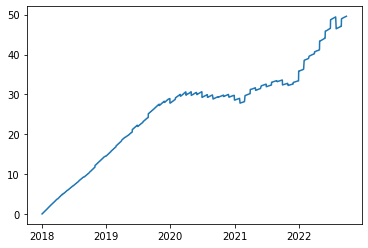

In [55]:
plt.plot(price_history_list[0].cum_units)

In [56]:
# Compute final value
price_history = price_history_list[0]
for i_fund in range(1,len(price_history_list)):
    price_history['cum_value'] += price_history_list[i_fund]['cum_value']
    price_history['fees'] += price_history_list[i_fund]['fees']
    price_history['deposits'] += price_history_list[i_fund]['deposits']
    
price_history.head()

,cum_value,cum_units,Open,High,Low,Close,Volume,deposits,units,fees
Date,,,,,,,,,,
2018-01-03,54.794521,0.061331,439.467500,447.297656,439.467500,446.710388,1664865,54.794521,0.061331,0.001233
2018-01-04,110.033925,0.122129,446.514674,451.212756,446.514674,450.625488,2309974,54.794521,0.060798,0.002476
2018-01-05,165.426214,0.182717,451.799996,453.953271,451.604230,452.191498,2721809,54.794521,0.060588,0.003724
2018-01-08,221.507139,0.242733,451.799996,457.476847,451.799996,456.498077,2239863,54.794521,0.060016,0.004985
2018-01-09,277.306135,0.302264,456.302360,460.804676,456.302360,460.217438,2563447,54.794521,0.059531,0.006237


11837.442023712914


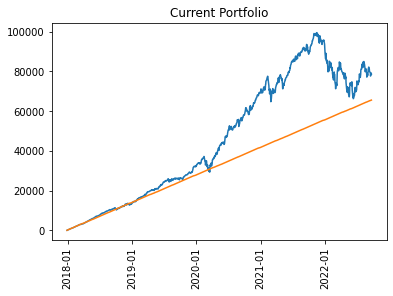

In [66]:
plt.plot(price_history['cum_value'])
plt.plot()
plt.plot(price_history['deposits'].cumsum())
plt.xticks(rotation = 90)
plt.title('Current Portfolio')
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(1,6))
profit = price_history["cum_value"][-2]-price_history['deposits'].sum()-price_history['fees'].sum()
print(profit)